<a href="https://colab.research.google.com/github/kralim/n0thing/blob/main/yolo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6220 (delta 5), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6220/6220), 13.48 MiB | 28.40 MiB/s, done.
Resolving deltas: 100% (4206/4206), done.


In [6]:
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

/content/keras-retinanet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/keras-retinanet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp38-cp38-linux_x86_64.whl size=183865 sha256=c4693cc3c47da910f55d8796b22ab2178276522bd266aada745652a48e1e7530
  Stored in directory: /root/.cache/pip/wheels/68/58/4e/8be58184393d8172c0cfc492d89ccfd890df58660b6308249f
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=f328b0ac292da72734dae30fe6da8ab4cbeb180100f87b691171244a6a1e0b2d
  Stored in directory: /root/.cache/pip/wheels/be/90/98/9d455f04a7ca277366b36c660c89d171ff5abb7bdd8a8b8e75
Successfully built keras-retinanet keras-resnet
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.8/keras_retinanet/u

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image
import cv2

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import xml.etree.ElementTree as ET

In [8]:
df_train = pd.DataFrame()
for filename in os.listdir('/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/'):
    if filename.split('.')[1] == 'xml':
        converted_data_train = {
        'image_name': [],
        'x_min': [],
        'y_min': [],
        'x_max': [],
        'y_max': [],
        'class_name': [],}

        tree = ET.parse("/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/" +filename)
        root = tree.getroot()
        imname = root.find('filename').text
        converted_data_train['image_name'] ="/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/" + imname

        for boxes in root.iter('object'):
            ymin, xmin, ymax, xmax = None, None, None, None
            objname = boxes.find("name").text
            converted_data_train['class_name'] = objname
            for box in boxes.findall("bndbox"):
                ymin = int(box.find("ymin").text)
                xmin = int(box.find("xmin").text)
                ymax = int(box.find("ymax").text)
                xmax = int(box.find("xmax").text)
                converted_data_train['x_min'] = int(xmin)
                converted_data_train['y_min'] = int(ymin)
                converted_data_train['x_max'] = int(xmax)
                converted_data_train['y_max'] = int(ymax)
            df_train = df_train.append(converted_data_train, ignore_index=True)
          

        

In [9]:
def show_image_with_boxes(df):
  filepath = df.sample()['image_name'].values[0]


  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))

  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(0, 255, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show()


In [10]:
df_train

,image_name,x_min,y_min,x_max,y_max,class_name
0,/content/drive/MyDrive/Veri-Materyaller/ChessD...,2093.0,311.0,2765.0,1665.0,black-king
1,/content/drive/MyDrive/Veri-Materyaller/ChessD...,1724.0,960.0,2108.0,1406.0,black-king
2,/content/drive/MyDrive/Veri-Materyaller/ChessD...,2106.0,370.0,2688.0,1524.0,black-bishop
3,/content/drive/MyDrive/Veri-Materyaller/ChessD...,1742.0,427.0,2431.0,1565.0,black-pawn
4,/content/drive/MyDrive/Veri-Materyaller/ChessD...,1921.0,127.0,2736.0,1750.0,black-queen
...,...,...,...,...,...,...
393,/content/drive/MyDrive/Veri-Materyaller/ChessD...,2333.0,1386.0,2536.0,1588.0,white-bishop
394,/content/drive/MyDrive/Veri-Materyaller/ChessD...,2098.0,1378.0,2301.0,1583.0,white-knight
395,/content/drive/MyDrive/Veri-Materyaller/ChessD...,2045.0,1696.0,2248.0,1899.0,black-knight
396,/content/drive/MyDrive/Veri-Materyaller/ChessD...,2375.0,1651.0,2589.0,1859.0,black-bishop


In [11]:
df_train = df_train[['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name']]

In [12]:
df_train = df_train.astype({"x_min": int, "y_min": int, "x_max": int, "y_max": int})

[1107, 286, 2024, 1412]
[2141, 320, 3107, 1447]


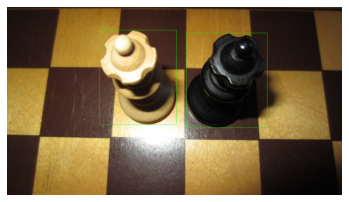

In [13]:
show_image_with_boxes(df_train)

In [14]:
df_train.to_csv('annotations.csv', index=False, header=None)

In [15]:
df_train.class_name.unique()

array(['black-king', 'black-bishop', 'black-pawn', 'black-queen',
       'black-rook', 'black-knight', 'white-pawn', 'white-bishop',
       'white-knight', 'white-rook', 'white-queen', 'white-king'],
      dtype=object)

In [16]:
classes = ['black-pawn', 'white-pawn', 'black-bishop', 'black-rook',
       'black-knight', 'white-bishop', 'white-queen', 'black-king',
       'white-knight', 'white-king', 'black-queen', 'white-rook']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')

In [17]:
!head classes.csv

black-pawn,0
white-pawn,1
black-bishop,2
black-rook,3
black-knight,4
white-bishop,5
white-queen,6
black-king,7
white-knight,8
white-king,9


In [18]:
!head annotations.csv

/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2017.JPG,2093,311,2765,1665,black-king
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2018.JPG,1724,960,2108,1406,black-king
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2015.JPG,2106,370,2688,1524,black-bishop
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2022.JPG,1742,427,2431,1565,black-pawn
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2020.JPG,1921,127,2736,1750,black-queen
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2021.JPG,1975,916,2503,1537,black-queen
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2009.JPG,2075,447,2516,1080,black-rook
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2012.JPG,1857,886,2298,1355,black-knight
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_2010.JPG,1777,1,2560,1670,black-knight
/content/drive/MyDrive/Veri-Materyaller/ChessDetection/data/IMG_204

In [19]:
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

In [20]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL);

Downloaded pretrained model to snapshots/_pretrained_model.h5


In [ ]:
!keras_retinanet/bin/train.py  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 4 \
  --steps 20 \
  --epochs 80 \
  csv annotations.csv classes.csv

Creating model, this may take a second...
2023-01-27 14:40:05.147372: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)           

In [ ]:
!ls snapshots

In [ ]:
model = models.load_model("./snapshots/resnet50_csv_76.h5", backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

In [ ]:
def show_image_with_predictions(df, threshold=0.6):

  row = df.sample()
  filepath = row['image_name'].values[0]
  print("filepath:", filepath)

  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print("im.shape:", im.shape)
  im = im[:,:,:3]
  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))
  imp = preprocess_image(im)
  imp, scale = resize_image(im)
  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )
  boxes /= scale
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < threshold:
      break
    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)
    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 2
    color = (255, 0, 0) 
    thickness = 2 
    org = (box[0]-25,box[1]-25)
    im = cv2.putText(im, caption, org, font,  fontScale, color, thickness, cv2.LINE_AA) 
    #draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

In [ ]:
show_image_with_predictions(df_train, threshold=0.6)

In [ ]:
show_image_with_predictions(df_train, threshold=0.6)

In [ ]:
show_image_with_predictions(df_train, threshold=0.8)